# How to place wire cuts using a single-qubit `CutWire` instruction

This how-to guide is intended to demonstrate how to place wire cuts using single-qubit `CutWire` instructions, which may at times be more convenient than specifying them as two-qubit `Move` instructions.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from qiskit_addon_cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from qiskit_addon_cutting.instructions import CutWire
from qiskit_addon_cutting import cut_wires, expand_observables

### Prepare a circuit for cutting

As in the [tutorial for wire cutting](../tutorials/03_wire_cutting_via_move_instruction.ipynb), we have used a circuit inspired by Fig. 1(a) of [arXiv:2302.03366v1](https://arxiv.org/abs/2302.03366v1).  The cut locations are marked manually here with `CutWire` instructions.

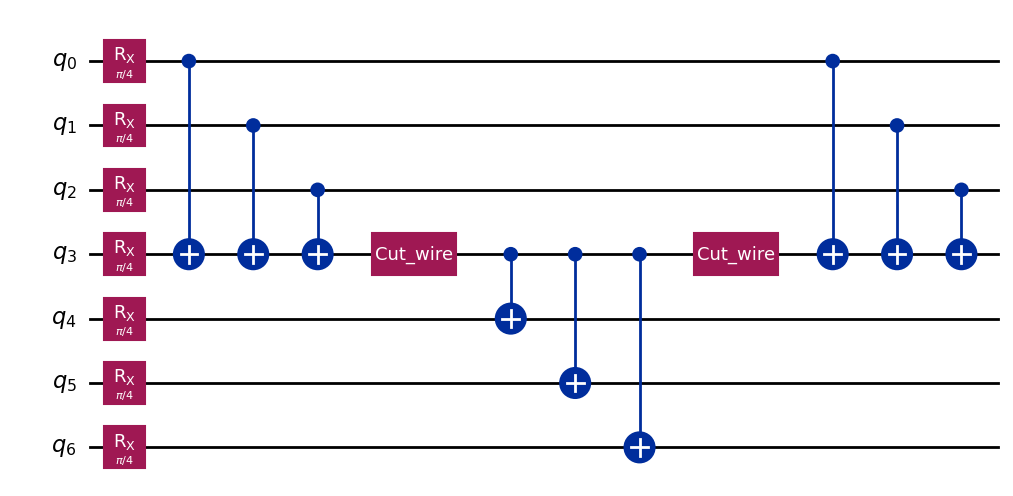

In [2]:
qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.append(CutWire(), [3])
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.append(CutWire(), [3])
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.draw("mpl")

### Recover the uncut circuit

`CutWire` instructions decompose to nothing (they are equivalent to the identity), so the uncut circuit can be recovered as follows:

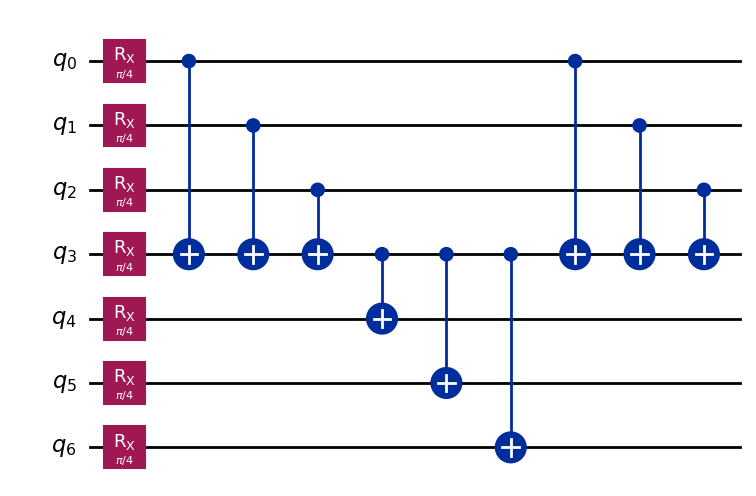

In [3]:
qc_0.decompose("cut_wire").draw("mpl")

### Specify an observable

This observable has 7 qubits, just like the original circuit.

In [4]:
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

### Transform cuts to moves

The next step is to call `cut_wires`, which transforms each `CutWire` into a `TwoQubitQPDGate` which wraps a `Move` instruction.  An additional qubit is added to the circuit for each `CutWire` in the input circuit.

Notice that, unlike in the [wire cutting tutorial](../tutorials/03_wire_cutting_via_move_instruction.ipynb), where `Move` operations were placed manually, this function does not result in the _re_-use of a qubit.  Because any method for qubit re-use is based on heuristics, this function naively allocates an additional qubit for each cut.  Users wishing to re-use qubits might wish to experiment with [qiskit-qubit-reuse](https://github.com/qiskit-community/qiskit-qubit-reuse).

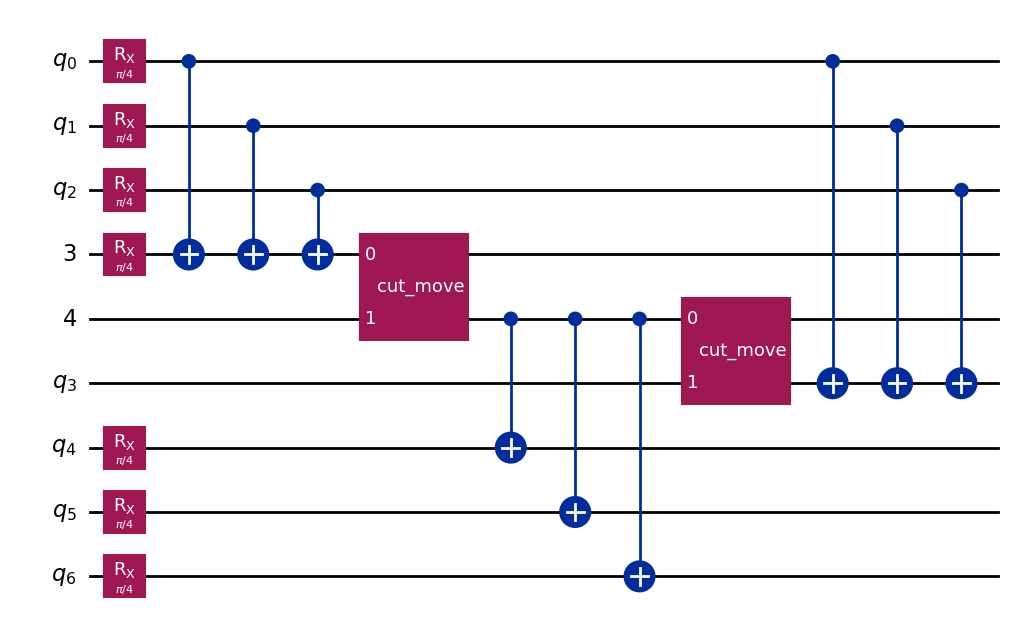

In [5]:
qc_1 = cut_wires(qc_0)
qc_1.draw("mpl")

### Update the observable terms to account for the extra qubit

The transformed circuit contains additional qubits (one for each `CutWire` instruction), so the observables must be updated for the new circuit.  This can be done using the `expand_observables` function. Since the observable coefficients are ignored until reconstruction of the final expectation value, the input and output types of the observables for ``expand_observables`` are ``PauliList``s.

The resulting observables have 9 qubits, just like the transformed circuit.

In [6]:
observable_expanded_paulis = expand_observables(observable.paulis, qc_0, qc_1)
observable_expanded_paulis

PauliList(['ZIIIIIIII', 'IIIZIIIII', 'IIIIIIIIZ'])

### Separate the circuit and observables

In this case, `partition_labels` need not be passed to `partition_problem`, as the labels can be determined automatically from the connectivity of the circuit.

In [7]:
partitioned_problem = partition_problem(
    circuit=qc_1, observables=observable_expanded_paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

From here forward, the cutting workflow is the same as usual, but the remaining steps are spelled out here explicitly so one can follow along with the results.

### Visualize the decomposed problem

Notice that once the circuits have been cut, some of the instructions are able to commute past each other.  For instance, in subcircuit "A", half of the second `Move` operation is actually the _first_ operation on the final qubit.

In [8]:
subobservables

{0: PauliList(['IIIII', 'ZIIII', 'IIIIZ']),
 1: PauliList(['ZIII', 'IIII', 'IIII'])}

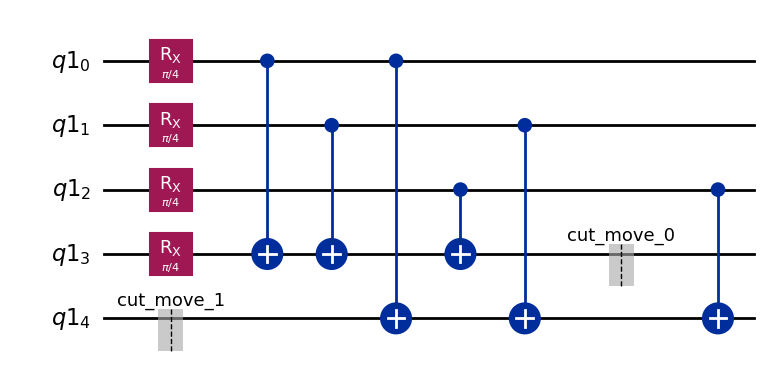

In [9]:
subcircuits[0].draw("mpl")

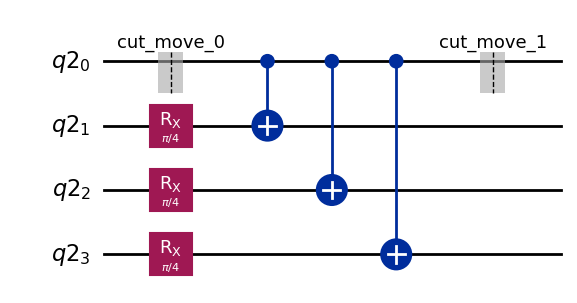

In [10]:
subcircuits[1].draw("mpl")

### Generate and run the cutting experiments; reconstruct and compare against uncut expectation values

In [11]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [12]:
sampler = SamplerV2()
results = {
    label: sampler.run(subexperiment, shots=2**12).result()
    for label, subexperiment in subexperiments.items()
}

In [13]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

In [14]:
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc_0.decompose("cut_wire"), observable)]).result()[0].data.evs
)
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 1.56514591
Exact expectation value: 1.59099026
Error in estimation: -0.02584435
Relative error in estimation: -0.01624419
